# Exploring the possiblities with Python package PyDy

In [1]:
from __future__ import print_function, division
from sympy import symbols, simplify
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)
from sympy.physics.mechanics import inertia, RigidBody
from sympy import trigsimp
from sympy.physics.mechanics import KanesMethod
from pydy.codegen.ode_function_generators import generate_ode_function
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

## Reference frames

In [56]:
inertial_frame = ReferenceFrame('I')
ship_frame = ReferenceFrame('S')

In [57]:
psi = dynamicsymbols('psi') #Ship heading
X = dynamicsymbols('X') #Ship position in inertial frame
Y = dynamicsymbols('Y') #Ship position in inertial frame
x = dynamicsymbols('x') #Position in ship frame
y = dynamicsymbols('y') #Position in ship frame



In [58]:
ship_frame.orient(inertial_frame, 'Axis', (psi, inertial_frame.z))

In [59]:
#phi = dynamicsymbols('phi') #Ship roll
#theta = dynamicsymbols('theta') #Ship pitch

In [60]:
ship_frame.dcm(inertial_frame)

Matrix([
[ cos(psi), sin(psi), 0],
[-sin(psi), cos(psi), 0],
[        0,        0, 1]])

In [ ]:
ship_frame.x

## Define some points

In [61]:
starting_point = Point('Start')
ship_origo = Point('O')
ship_mass_center = Point('c_G')
x_cg = symbols('x_cg')
y_cg = symbols('y_cg')
z_cg = symbols('z_cg')

ship_mass_center.set_pos(ship_origo, x_cg*ship_frame.x + y_cg*ship_frame.y + z_cg*ship_frame.z)

## Kinematical Differential Equations

In [62]:
r = dynamicsymbols('r') # Yaw rate
U = dynamicsymbols('U') # Ship speed in inertial frame
V = dynamicsymbols('V') # Ship speed in inertial frame
u = dynamicsymbols('u') # Ship speed in ship frame
v = dynamicsymbols('v') # Ship speed in ship frame



In [117]:
kinematical_differential_equations = [r - psi.diff(),
                                      U - X.diff(),
                                      V - Y.diff(),
]
kinematical_differential_equations

[r - psi', U - X', V - Y']

## Angular Velocities

In [118]:
ship_frame.set_ang_vel(inertial_frame,r*inertial_frame.z)

In [176]:
?ship_frame.set_ang_vel

In [119]:
ship_frame.ang_vel_in(inertial_frame)

r*I.z

## Linear Velocities

In [120]:
starting_point.set_vel(inertial_frame, 0)
ship_origo.set_vel(inertial_frame,U*inertial_frame.x + V*inertial_frame.y)
ship_origo.vel(inertial_frame)

U*I.x + V*I.y

In [121]:
ship_mass_center.v2pt_theory(ship_origo, inertial_frame, ship_frame)

U*I.x + V*I.y - y_cg*r*S.x + x_cg*r*S.y

## Mass

In [122]:
ship_mass = symbols('m_S')

## Inertia

In [123]:
Izz = symbols('I_zz')

In [124]:
ship_dyadic = inertia(ship_frame, 0, 0, Izz)

In [125]:
ship_dyadic

I_zz*(S.z|S.z)

In [126]:
ship_dyadic.to_matrix(ship_frame)

Matrix([
[0, 0,    0],
[0, 0,    0],
[0, 0, I_zz]])

In [127]:
ship_central_inertia = (ship_dyadic, ship_mass_center)

In [128]:
ship = RigidBody('Ship', ship_mass_center, ship_frame,
                      ship_mass, ship_central_inertia)

## Equations of Motion

In [129]:
coordinates = [psi,X, Y]
coordinates

[psi, X, Y]

In [130]:
speeds = [r,U, V]
speeds

[r, U, V]

In [131]:
kane = KanesMethod(inertial_frame, coordinates, speeds, kinematical_differential_equations)

In [154]:
dummy_force = symbols('force')
ship_force_vector = dummy_force * ship_frame.x
ship_force = (ship_mass_center, ship_force_vector)

resistance_force_symbol = symbols('R')
resistance_force_vector = resistance_force_symbol * ship_frame.x
ship_resistance = (ship_mass_center, resistance_force_vector)


In [155]:
loads = [ship_force,ship_resistance]

In [156]:
loads

[(c_G, force*S.x), (c_G, R*S.x)]

In [157]:
bodies = [ship]

In [158]:
bodies

[Ship]

In [159]:
fr, frstar = kane.kanes_equations(bodies = bodies,loads = loads)

In [160]:
trigsimp(fr + frstar)

Matrix([
[-R*y_cg - force*y_cg + m_S*(x_cg*sin(psi) + y_cg*cos(psi))*U' - m_S*(x_cg*cos(psi) - y_cg*sin(psi))*V' - (I_zz + m_S*(x_cg**2 + y_cg**2))*r'],
[             R*cos(psi) + force*cos(psi) + m_S*x_cg*r**2*cos(psi) - m_S*y_cg*r**2*sin(psi) + m_S*(x_cg*sin(psi) + y_cg*cos(psi))*r' - m_S*U'],
[             R*sin(psi) + force*sin(psi) + m_S*x_cg*r**2*sin(psi) + m_S*y_cg*r**2*cos(psi) - m_S*(x_cg*cos(psi) - y_cg*sin(psi))*r' - m_S*V']])

In [161]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

Matrix([
[1, 0, 0,                                    0,                                    0,                                   0],
[0, 1, 0,                                    0,                                    0,                                   0],
[0, 0, 1,                                    0,                                    0,                                   0],
[0, 0, 0,       I_zz + m_S*(x_cg**2 + y_cg**2), -m_S*(x_cg*sin(psi) + y_cg*cos(psi)), m_S*(x_cg*cos(psi) - y_cg*sin(psi))],
[0, 0, 0, -m_S*(x_cg*sin(psi) + y_cg*cos(psi)),                                  m_S,                                   0],
[0, 0, 0,  m_S*(x_cg*cos(psi) - y_cg*sin(psi)),                                    0,                                 m_S]])

In [162]:
forcing_vector = trigsimp(kane.forcing_full)
forcing_vector

Matrix([
[                                                                            r],
[                                                                            U],
[                                                                            V],
[                                                         -R*y_cg - force*y_cg],
[R*cos(psi) + force*cos(psi) + m_S*x_cg*r**2*cos(psi) - m_S*y_cg*r**2*sin(psi)],
[R*sin(psi) + force*sin(psi) + m_S*x_cg*r**2*sin(psi) + m_S*y_cg*r**2*cos(psi)]])

## Simulation

In [163]:
constants = [ship_mass,
             Izz,
            x_cg,
            y_cg,
            z_cg,
            dummy_force,
            resistance_force_symbol]

In [164]:
specified = []


right_hand_side = generate_ode_function(forcing_vector, coordinates,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

In [168]:
?right_hand_side

In [165]:
x0 = np.array([0,0,0,0,0,0])
x0

array([0, 0, 0, 0, 0, 0])

In [169]:
numerical_constants = np.array([
                             1,  # ship mass [kg]
                             1,  # ship Izz [kg*m2]
                             0,  # xg [m]
                             0,  # yg [m]
                             0,  # zg [m]
                             1,  # N
                             0.5, # N Resistance
]) 

In [170]:
numerical_specified = np.zeros(3)

args = {'constants': numerical_constants,
        'specified': numerical_specified}

frames_per_sec = 60
final_time = 5.0

t = np.linspace(0.0, final_time, final_time * frames_per_sec)

/Users/martinalexandersson/Dev/ForceMan/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


## Integrate the Equations of Motion

In [171]:
y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))

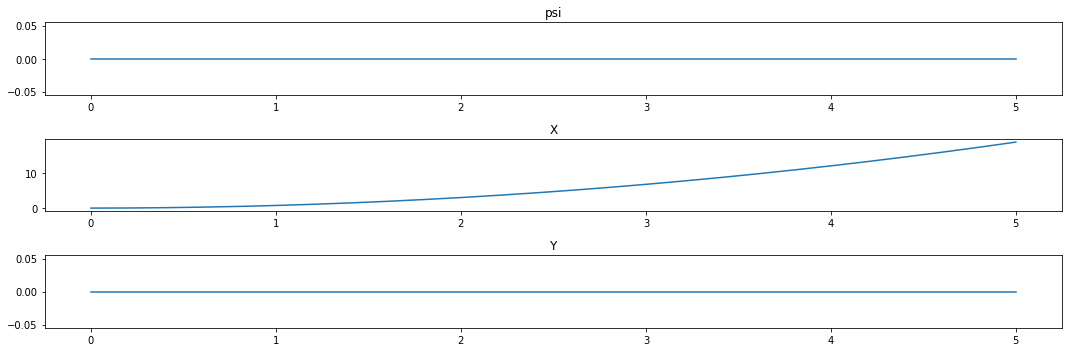

In [172]:
fig,axes = plt.subplots(nrows = 3)
fig.set_size_inches(15,5)

ax = axes[0]
ax.plot(t,y[:,0])
ax.set_title('psi')

ax = axes[1]
ax.plot(t,y[:,1])
ax.set_title('X')

ax = axes[2]
ax.plot(t,y[:,2])
ax.set_title('Y')

fig.tight_layout()

In [173]:
help(right_hand_side)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, r, p)
    
    Parameters
    x : ndarray, shape(6,)
        The state vector is ordered as such:
            - psi(t)
            - X(t)
            - Y(t)
            - r(t)
            - U(t)
            - V(t)
    t : float
        The current time.
    r : dictionary; ndarray, shape(0,); function
    
        There are three options for this argument. (1) is more flexible but
        (2) and (3) are much more efficient.
    
        (1) A dictionary that maps the specified functions of time to floats,
        ndarrays, or functions that produce ndarrays. The keys can be a single
        specified symbolic function of time or a tuple of symbols. The total
        number of symbols must be equal to 0. If the value is a
        function it must be o